## Speech to Text Converter

#### Converting Audio File and Converting it into Text 


#### Import necessary libraries

In [1]:
import os
import numpy as np
import librosa
from scipy.io import wavfile
import IPython.display as ipd
import warnings

warnings.filterwarnings("ignore")

In [2]:
pwd

'c:\\Users\\risha\\Documents\\KRMU\\nlp\\speech2lang-detect'

In [3]:
audio_data_path= "train/audio/"
labels=os.listdir(audio_data_path)
labels

['bed',
 'down',
 'five',
 'four',
 'left',
 'nine',
 'off',
 'right',
 'two',
 '_background_noise_']

#### Exploring the data

In [4]:

samples, sample_rate = librosa.load(audio_data_path + 'right'+ '/' + 'right_1.wav')

In [5]:
samples

array([-0.00062569, -0.00272571, -0.00366397, ..., -0.00229625,
       -0.00286611, -0.00197607], dtype=float32)

In [6]:
sample_rate

22050

In [8]:
ipd.Audio(samples, rate=sample_rate)

#### Data-preprocessing
We'll resample the sampling rate of the audio files to 8000 Hz.

In [9]:
import glob
import librosa

In [9]:
final_audio = []
final_label = []

# for label in labels:
#     print(label)
#     waves = [f for f in os.listdir(audio_data_path + label) if f.endswith('.wav')]
#     for wav in waves:
#         samples, sample_rate = librosa.load(audio_data_path + label + '/' + wav)
#         samples = librosa.resample(samples, sample_rate, 8000)
#         if(len(samples)== 8000) : 
#             final_audio.append(samples)
#             final_label.append(label)

for label in labels:
    print(label)
    waves = [f for f in os.listdir(audio_data_path + label) if f.endswith('.wav')]
    for wav_file in waves:
        samples, sample_rate = librosa.load(audio_data_path + label + '/' + wav_file)
        samples = librosa.resample(samples, orig_sr=sample_rate, target_sr=8000)
        if 7900 <= len(samples) <= 8100:  # check if sample length is within a range 
            final_audio.append(samples)
            final_label.append(label)

bed
down
five
four
left
nine
off
right
two
_background_noise_


In [10]:
len(final_audio)

6846

In [11]:
len(final_label)

6846

Since it's a multi-class classification problem, we'll do one-hot-encoding over the labels.

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(final_label)
classes= list(le.classes_)

In [13]:
classes

['bed', 'down', 'five', 'four', 'left', 'nine', 'off', 'right', 'two']

In [14]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [15]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

Since the input to a conv1D is a 3D array, we'll reshape all audio files from 2D to 3D.

In [16]:
final_audio = np.array(final_audio).reshape(-1,8000,1)

**Train and validation set preparation**

We'll consider 75% data for training set and 25% for validation set.


In [17]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(final_audio),np.array(y),stratify=y,test_size = 0.25,random_state=777,shuffle=True)

**Model Architecture** 

In [18]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.25)(conv)

#Dense Layer 2
conv = Dense(64, activation='relu')(conv)
conv = Dropout(0.25)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 884, 16)          0         
 1D)                                                         

In [19]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
mc = ModelCheckpoint('model/speech2text.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#### Model Training

In [20]:
history=model.fit(x_tr, y_tr ,epochs=30, callbacks=[mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/30
161/161 [==============================] - ETA: 0s - loss: 2.1413 - accuracy: 0.1868
Epoch 1: val_accuracy improved from -inf to 0.22138, saving model to model\speech2text.hdf5
161/161 [==============================] - 26s 154ms/step - loss: 2.1413 - accuracy: 0.1868 - val_loss: 2.0385 - val_accuracy: 0.2214
Epoch 2/30
161/161 [==============================] - ETA: 0s - loss: 1.9242 - accuracy: 0.2647
Epoch 2: val_accuracy improved from 0.22138 to 0.34054, saving model to model\speech2text.hdf5
161/161 [==============================] - 22s 139ms/step - loss: 1.9242 - accuracy: 0.2647 - val_loss: 1.7864 - val_accuracy: 0.3405
Epoch 3/30
161/161 [==============================] - ETA: 0s - loss: 1.6928 - accuracy: 0.3859
Epoch 3: val_accuracy improved from 0.34054 to 0.46846, saving model to model\speech2text.hdf5
161/161 [==============================] - 24s 152ms/step - loss: 1.6928 - accuracy: 0.3859 - val_loss: 1.5326 - val_accuracy: 0.4685
Epoch 4/30
161/161 [========

**Plotting loss and accuracy graphs wrt epochs**

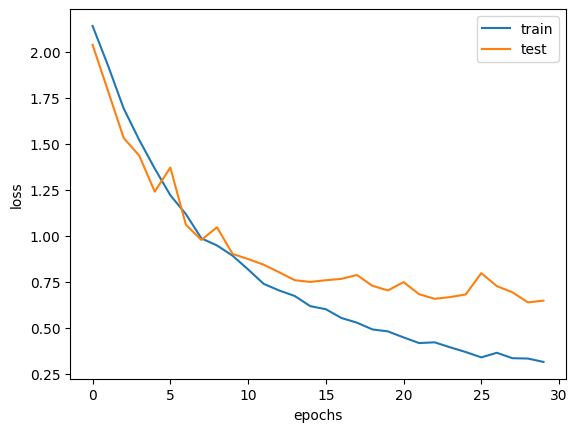

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

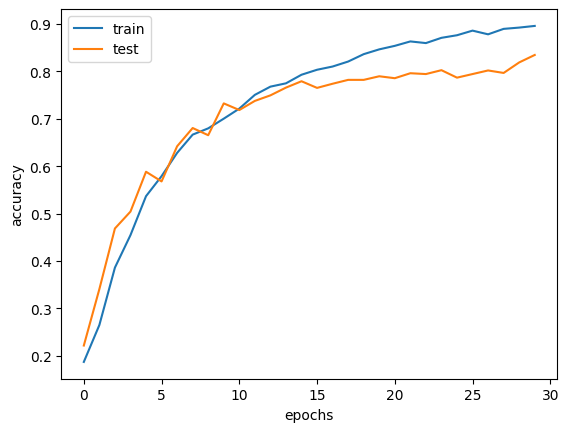

In [22]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

#### **Loading the saved model**
The saved model lies in "model" directory

In [23]:
from tensorflow.keras.models import load_model
model=load_model('model/speech2text.hdf5')

#### Doing predictions
Selecting an audio file randomly from the validation set and predicting it's text.

In [24]:
import random
index=random.randint(0,len(x_val)-1)
print("Index::",index)
samples=x_val[index].ravel()
print("Audio::",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Index:: 500
Audio:: nine


In [25]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [26]:
print("Text::",predict(samples))

1/1 [==============================] - 0s 299ms/step
Text:: nine


Predicting the text of test dataset i.e. an audio file placed in "sample" directory.

In [27]:
filepath='sample'

### reading the voice commands

In [32]:

samples, sample_rate = librosa.load(filepath + '/' + 'right_1.wav', sr = 16000)
samples = librosa.resample(samples, orig_sr=sample_rate, target_sr=8000)
ipd.Audio(samples,rate=8000)              

In [33]:
samples.shape

(8000,)

###  converting voice commands to text

In [51]:
predict(samples)

1/1 [==============================] - 0s 44ms/step


'right'

### recording own audio and save it in "recorded_file" folder 

In [50]:
import sounddevice as sd
from scipy.io.wavfile import write
import time
import os

def record_audio(duration=4, filename="recording.wav", freq=44100, channels=2):
    if not os.path.exists("recorded_file"):
        os.makedirs('recorded_file')

    filepath = os.path.join('recorded_file', filename)

    print("Starting recording in 3 sec")
    time.sleep(3)
    print("Started recording")
    recording = sd.rec(int(duration * freq), samplerate=freq, channels=channels)
    print("Recording finished")
    sd.wait()
    print("Saving audio")

    try:
        write(filepath, freq, recording)
    except:
        print("failed to save file.")

record_audio(duration=4, filename="audio.wav")

Starting recording in 3 sec
Started recording
Recording finished
Saving audio
